In [ ]:
import os
import sys
from typing import List


import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


ABS_PATH = %pwd
notebook_path = [idx for idx,ch in enumerate(ABS_PATH) if ch=='/']
notebooks_level_in_the_project = 2

PROJECT_PATH = ABS_PATH[:notebook_path[-notebooks_level_in_the_project]]
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from src.features.dataset import Dataset
from src.models.model_builder import Model
from src.features.metrics import CustomMeanIoU
from src.visualization.visualize import PredictionMasks
from src.features.evaluation_utils import (
    PredictionIoU,
    ConfusionMatrix,
    HistoryUtilities,
    History
)
from src.features.loss_functions import SemanticSegmentationLoss

In [ ]:
print(tf.__version__)

In [ ]:
VERSION = '10.0'

BATCH_SIZE = 8
IMG_HEIGHT = 512
IMG_WIDTH = 512
NUM_CLASSES = 5

# Load datasets

In [ ]:
DATASET_PATH = PROJECT_PATH + '/data/processed/'
landcover_dataset = Dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, BATCH_SIZE)
train_dataset, val_dataset, test_dataset = landcover_dataset.generate_datasets()

print("Train Dataset:", train_dataset)
print("Number of images in Train Dataset:", BATCH_SIZE * len(train_dataset))
print("Val Dataset:", val_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(val_dataset))
print("Test Dataset:", test_dataset)
print("Number of images in Val Dataset:", BATCH_SIZE * len(test_dataset))

# Class balance 

In [ ]:
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance().plot.bar(y="pixel_count", xlabel="Class name", ylabel="Count")
landcover_dataset.get_dataframe_of_previously_calculated_class_balance_class_balance()

# DeepLabv3+
## Model architecture
https://keras.io/examples/vision/deeplabv3_plus/

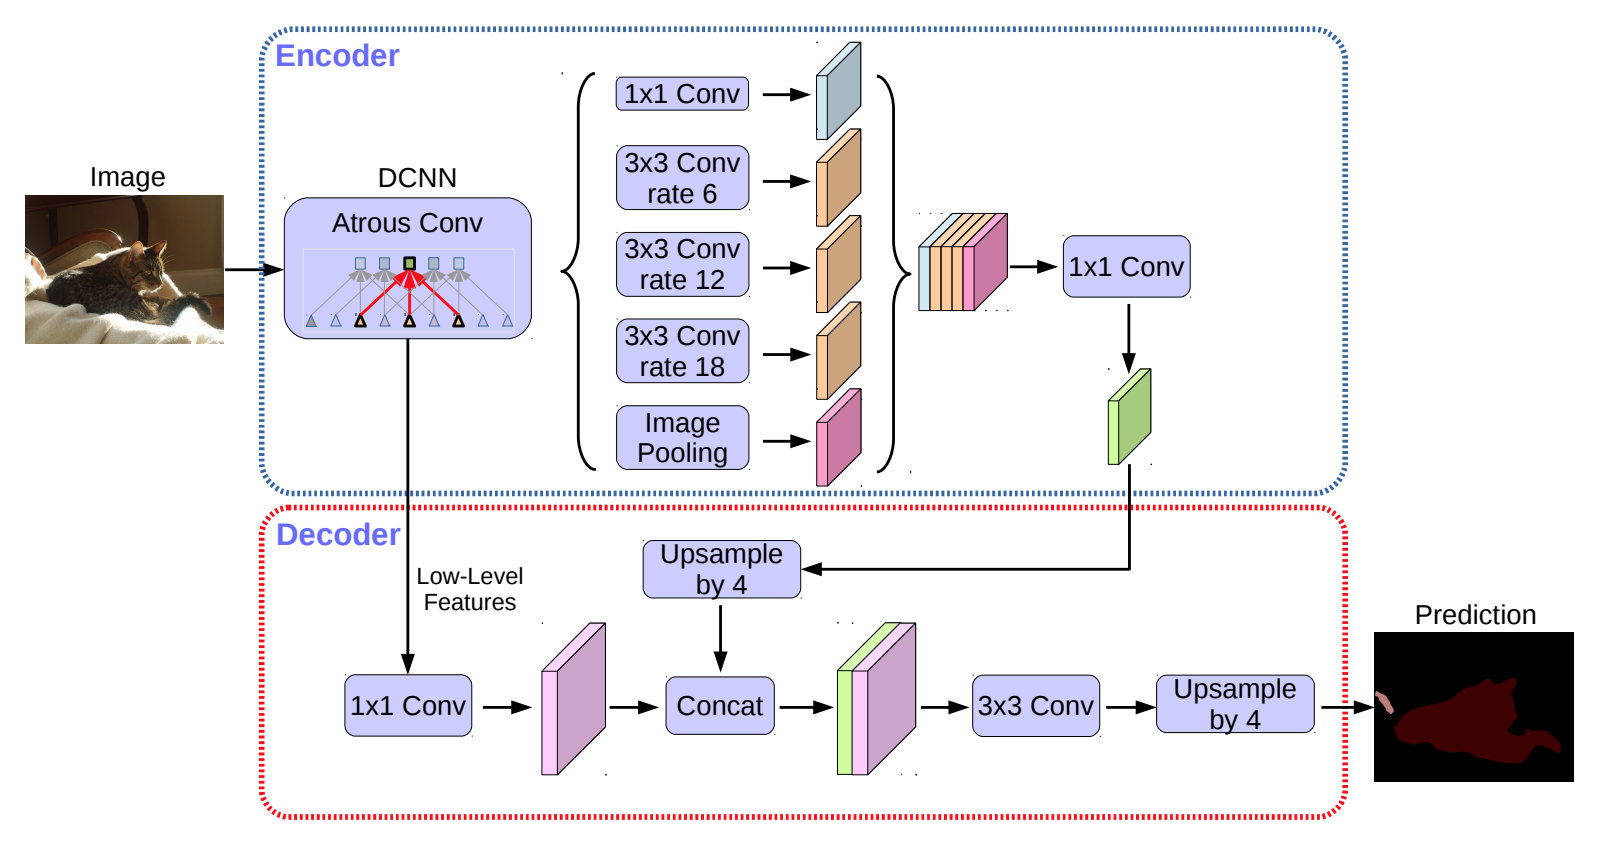

## Create model object

In [ ]:
model_creator = Model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Evaluation utilities

In [ ]:
custom_mIoU_metric = CustomMeanIoU(num_classes=NUM_CLASSES, name='mIoU')

## Callbacks
### Model checkpoint

In [ ]:
def create_folders(paths: List[str]):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)

In [ ]:
path_best_dice_loss = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_dice_loss/checkpoint'
dir_path_dice_loss= PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_dice_loss'
path_best_miou = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_miou/checkpoint'
dir_path_miou = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}/best_miou'


create_folders([
    dir_path_dice_loss,
    dir_path_miou,
])

In [ ]:
best_val_loss = tf.keras.callbacks.ModelCheckpoint(
    path_best_dice_loss,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

best_miou = tf.keras.callbacks.ModelCheckpoint(
    path_best_miou,
    monitor='val_mIoU',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)

### Early stopping

In [ ]:
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3,
                                                           mode='min')

### Learning rate schedule [optimizer]

In [ ]:
# EPOCHS = 6

# NUM_TRAIN_IMAGES = BATCH_SIZE * len(train_dataset)
# NUM_VAL_IMAGES = BATCH_SIZE * len(val_dataset)

# initial_learning_rate = 0.0001
# final_learning_rate = 0.00001
# learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/EPOCHS)
# steps_per_epoch = int(NUM_TRAIN_IMAGES/BATCH_SIZE)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate=initial_learning_rate,
#                 decay_steps=steps_per_epoch,
#                 decay_rate=learning_rate_decay_factor,
#                 staircase=True)

### Get current lr [metric]

In [ ]:
# #  https://stackoverflow.com/questions/47490834/how-can-i-print-the-learning-rate-at-each-epoch-with-adam-optimizer-in-keras

# def get_lr_metric(optimizer):
#     def lr(y_true, y_pred):
#         return optimizer._decayed_lr(tf.float32)
#     return lr

# optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# lr_metric = get_lr_metric(optimizer_adam)

## Training settings

In [ ]:
# creating a model
WEIGHTS = "cityscapes"
SHOULD_FREEZE_LAYERS = True
LAST_LAYER_TO_FREEZE = 359  # All from the top up to 359 will be frozen
ACTIVATION = "softmax"
DEEPLAB_VERSION = "original"

# compiling the model
OPTIMIZER = tf.keras.optimizers.Adam(0.001)
LOSS = SemanticSegmentationLoss(NUM_CLASSES).soft_dice_loss
METRICS = ["accuracy", custom_mIoU_metric]

# training the model
EPOCHS = 6
TRAINING_DATA_PATH = PROJECT_PATH + f'/notebooks/templates/results/DeepLabv3+/{VERSION}'
CALLBACKS = [
    early_stopping_val_loss,
    best_val_loss,
    best_miou
]


## Training

In [ ]:
model = model_creator.get_deeplab_model(
    weights=WEIGHTS,
    freeze_layers = SHOULD_FREEZE_LAYERS,
    custom_freeze_border = LAST_LAYER_TO_FREEZE,
    activation = ACTIVATION,
    architecture_version=DEEPLAB_VERSION,
)

# tf.keras.utils.plot_model(model, to_file=data_save_dir + '/Deeplabv3plus_v8_5.jpg', show_shapes=True)

model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

### Save history to file

In [ ]:
history_utils = HistoryUtilities()
history_utils.dump_model_history_to_file(history, TRAINING_DATA_PATH, "history")

History([history]).display_history_plots()

## Evaluate the model

In [ ]:
model.load_weights(path_best_dice_loss)

In [ ]:
iou_every_class = PredictionIoU(model, test_dataset, NUM_CLASSES).get_iou_for_every_class()
iou_every_class

In [ ]:
PredictionMasks(model, landcover_dataset, NUM_CLASSES).display_overlay_predictions_for_test_set(4, (25, 25))

### Confusion matrix

In [ ]:
df_matrix = ConfusionMatrix(model, test_dataset, NUM_CLASSES).get_dataframe()

pp_matrix(df_matrix, cmap="magma")

In [ ]:
model.evaluate(test_dataset)

# Further training the model
## You may change the settings
E.g. Freeze less layers, change optimizer's learning rate, add metric, etc.

In [ ]:
model = model_creator.get_deeplab_model(
    weights=WEIGHTS,
    freeze_layers = SHOULD_FREEZE_LAYERS,
    custom_freeze_border = LAST_LAYER_TO_FREEZE - 40,  # freeze 40 layers less than before 
    activation = ACTIVATION,
    architecture_version=DEEPLAB_VERSION,
)

model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

# load weights with best results
model.load_weights(path_best_dice_loss)

history_2 = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

In [ ]:
History([history, history_2]).display_history_plots(TRAINING_DATA_PATH)